In [1]:
#Importing required libraries
import os
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import urllib.request, io
import requests

from PIL import Image, ImageDraw
from requests.exceptions import HTTPError
from shutil import copyfileobj
from tqdm.notebook import tqdm
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Define variables
blues_palette = sns.color_palette("Blues_r", n_colors=20)
reds_palette = sns.color_palette("Reds_r", n_colors=20)

blue = blues_palette[1]
red = reds_palette[1]
two_colors = [blue, red]
custom_params = {'lines.linewidth': 1,}
# seaborn
sns.set()
sns.set_theme(
    style="whitegrid", 
    palette=blues_palette,
    rc=custom_params)

indx = 'id'
root = Path('./weq')


In [3]:
def read_json(file):
    """Read a json file."""
    f = open(file)
    data = json.load(f)
    f.close()
    return data

def get_info(json_data):
    return pd.json_normalize(json_data['info'])

def get_licenses(json_data):
    return pd.json_normalize(json_data['licenses'])

def get_image_data(json_data):
    df = pd.json_normalize(json_data['images'])
    return df.set_index(indx)

def get_annotations(json_data):
    df = pd.json_normalize(json_data['annotations'])
    return df.set_index(indx)

def get_categories(json_data):
    df = pd.json_normalize(json_data['categories'])
    return df.set_index(indx)

def download_image_by_url(url):
    with urllib.request.urlopen(url) as u:
        img = Image.open(u)
        u.close()
    return img

def download_image_by_id(data, image_id, url_type='coco_url'):
    url = data.loc[image_id][url_type]
    return download_image_by_url(url)

def load_train_image(file_name):
    path = Cfg.IMAGE_DIRECTORY / file_name
    return Image.open(path)

def load_train_image_by_id(data, image_id):
    file_name = data.loc[image_id]['file_name']
    return load_train_image(file_name)

def draw_rectangle(image, xy, color='red'):
    img = ImageDraw.Draw(image) 
    img.rectangle(xy, outline=color, width=3)
    return image



In [4]:
train_data = pd.read_csv(root / 'multilabel_classification/train.csv').set_index(indx)
category_keys = pd.read_csv(root / 'category_key.csv').set_index(indx)
display(train_data)
display(category_keys)

,categories
id,
3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0]
dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0]
4a7f2199-772d-486d-b8e2-b651246316b5,[1.0]
3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]"
3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]"
...,...
701715fe-b278-4310-ac1d-cca8ddacc830,[283.0]
45e73fdd-d8a2-4ee1-abc7-3e34d2dfa82a,[283.0]
676b982a-deeb-46ee-b47d-8a97a1b0c76c,[283.0]


,name,supercat
id,,
1,Actiniaria,Anemone
2,Actinernus,Anemone
3,Actiniidae,Anemone
4,Actinoscyphia,Anemone
5,Bolocera,Anemone
...,...,...
286,Polychaeta,Worm
287,Polynoidae,Worm
288,Sabellidae,Worm


In [5]:
display(train_data)

,categories
id,
3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0]
dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0]
4a7f2199-772d-486d-b8e2-b651246316b5,[1.0]
3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]"
3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]"
...,...
701715fe-b278-4310-ac1d-cca8ddacc830,[283.0]
45e73fdd-d8a2-4ee1-abc7-3e34d2dfa82a,[283.0]
676b982a-deeb-46ee-b47d-8a97a1b0c76c,[283.0]


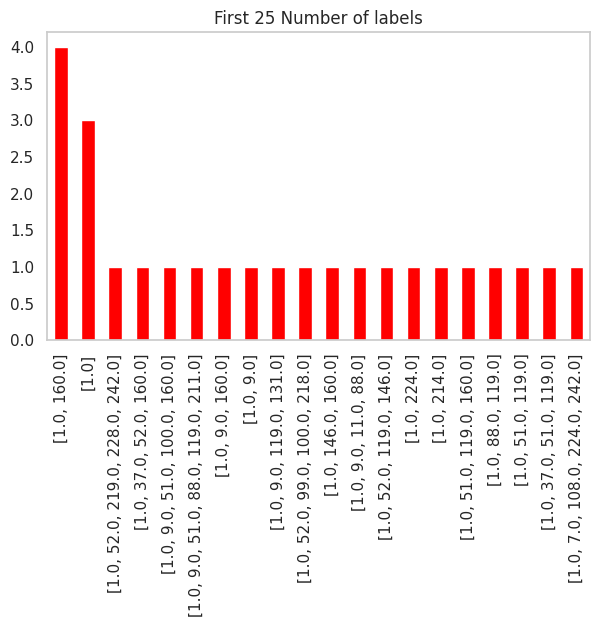

In [6]:
# show frequencies
plt.figure(figsize=(7,4))
train_data.iloc[:25].categories.value_counts().plot(kind='bar', color='#FF0000')
plt.title('First 25 Number of labels')
plt.grid()
plt.show()

In [7]:
train_data['num_categories'] = train_data['categories'].apply(lambda x: len(json.loads(x)))

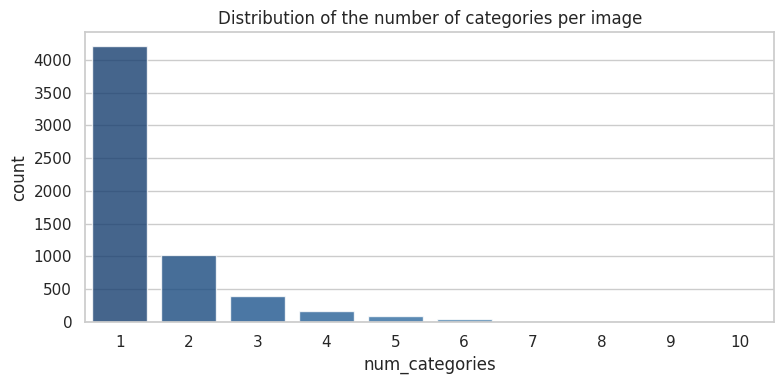

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

sns.countplot(data=train_data, x='num_categories', palette=blues_palette, alpha=0.8, ax=ax)
ax.set_title('Distribution of the number of categories per image')

plt.tight_layout()
plt.show()

In [9]:
display(category_keys)

,name,supercat
id,,
1,Actiniaria,Anemone
2,Actinernus,Anemone
3,Actiniidae,Anemone
4,Actinoscyphia,Anemone
5,Bolocera,Anemone
...,...,...
286,Polychaeta,Worm
287,Polynoidae,Worm
288,Sabellidae,Worm


In [10]:
category_count = pd.DataFrame(category_keys['supercat'].value_counts()).reset_index()
category_count.columns = ['supercat', 'count']
category_count['%'] = np.round(category_count['count'] / len(category_keys), 4) * 100
category_count.set_index('supercat', inplace=True)

category_count

,count,%
supercat,,
Fish,46,15.86
Sea star,36,12.41
Glass sponge,23,7.93
Sea cucumber,22,7.59
Sea fan,22,7.59
Eel,17,5.86
Sea pen,16,5.52
Crab,15,5.17
Gastropod,14,4.83


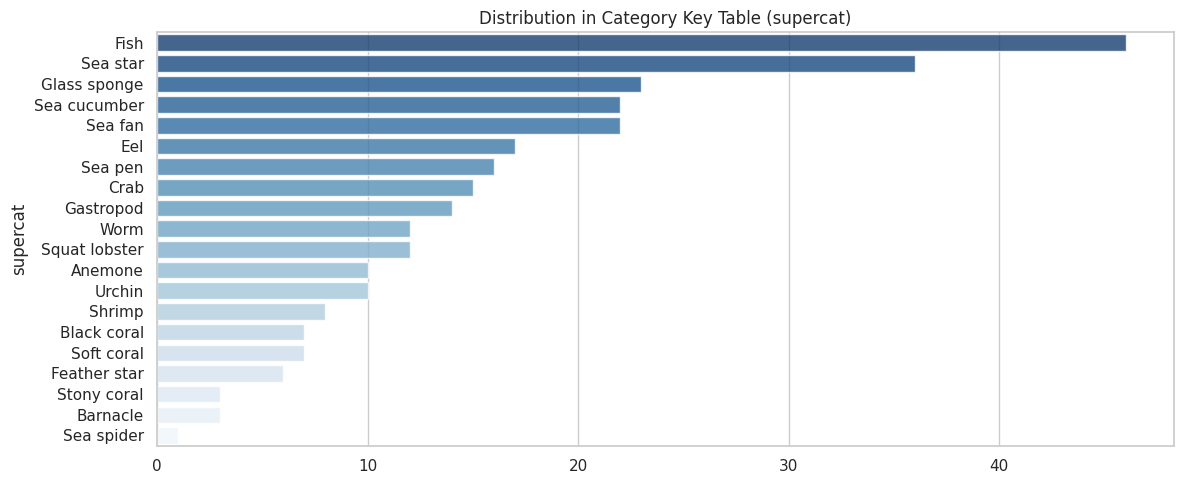

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

df = category_count['count']

sns.barplot(x=df.values, y=df.index, palette=blues_palette, alpha=0.8, ax=ax)
ax.set_title('Distribution in Category Key Table (supercat)')

plt.tight_layout()
plt.show()

In [12]:
object_detection_train = read_json(root / 'object_detection/train.json')

display(get_info(object_detection_train))
display(get_licenses(object_detection_train))

,year,version,description,contributor,url,date_created
0,2023,0,Generated by FathomNet,FathomNet,https://fathomnet.org,2023/01/26


,id,name,url
0,0,FathomNet,http://fathomnet.org/fathomnet/#/license


In [13]:
train_image_data = get_image_data(object_detection_train)
display(train_image_data)

,width,height,file_name,license,flickr_url,coco_url,date_captured
id,,,,,,,
1,720,368,3b6f01ae-5bde-434d-9b06-79b269421ed6.png,0,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34
2,720,368,dce21f7c-20e5-482b-bd90-c038f8464c03.png,0,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:38
3,720,368,4a7f2199-772d-486d-b8e2-b651246316b5.png,0,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:44
4,720,368,3bddedf6-4ff8-4e81-876a-564d2b03b364.png,0,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 17:54:14
5,720,369,3f735021-f5de-4168-b139-74bf2859d12a.png,0,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 19:00:00
...,...,...,...,...,...,...,...
5946,720,366,701715fe-b278-4310-ac1d-cca8ddacc830.png,0,https://fathomnet.org/static/m3/framegrabs/Doc...,https://fathomnet.org/static/m3/framegrabs/Doc...,2011-06-05 18:07:34
5947,1920,1079,45e73fdd-d8a2-4ee1-abc7-3e34d2dfa82a.png,0,https://fathomnet.org/static/m3/framegrabs/Doc...,https://fathomnet.org/static/m3/framegrabs/Doc...,2011-06-05 18:22:23
5948,1920,1080,676b982a-deeb-46ee-b47d-8a97a1b0c76c.png,0,https://fathomnet.org/static/m3/framegrabs/Doc...,https://fathomnet.org/static/m3/framegrabs/Doc...,2015-09-17 14:17:29


In [14]:
def get_annotations(json_data):
    df = pd.json_normalize(json_data['annotations'])
    return df.set_index(indx)

annotation_data = get_annotations(object_detection_train)
display(annotation_data)

,image_id,category_id,segmentation,area,bbox,iscrowd
id,,,,,,
1,1,1.0,[],7869.0,"[347.0, 188.0, 129.0, 61.0]",0
2,2,1.0,[],8775.0,"[346.0, 191.0, 135.0, 65.0]",0
3,3,1.0,[],8768.0,"[343.0, 192.0, 137.0, 64.0]",0
4,4,88.0,[],315.0,"[623.0, 95.0, 21.0, 15.0]",0
5,4,1.0,[],440.0,"[361.0, 175.0, 22.0, 20.0]",0
...,...,...,...,...,...,...
23700,5948,283.0,[],4360.0,"[698.0, 544.0, 40.0, 109.0]",0
23701,5949,286.0,[],3792.0,"[532.0, 440.0, 48.0, 79.0]",0
23702,5949,286.0,[],3484.0,"[609.0, 426.0, 52.0, 67.0]",0


In [15]:
train_image_data = get_image_data(object_detection_train)
display(train_image_data)
train_image_data['num_objects'] = annotation_data.groupby(by='image_id').count()['category_id']

,width,height,file_name,license,flickr_url,coco_url,date_captured
id,,,,,,,
1,720,368,3b6f01ae-5bde-434d-9b06-79b269421ed6.png,0,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34
2,720,368,dce21f7c-20e5-482b-bd90-c038f8464c03.png,0,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:38
3,720,368,4a7f2199-772d-486d-b8e2-b651246316b5.png,0,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:44
4,720,368,3bddedf6-4ff8-4e81-876a-564d2b03b364.png,0,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 17:54:14
5,720,369,3f735021-f5de-4168-b139-74bf2859d12a.png,0,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 19:00:00
...,...,...,...,...,...,...,...
5946,720,366,701715fe-b278-4310-ac1d-cca8ddacc830.png,0,https://fathomnet.org/static/m3/framegrabs/Doc...,https://fathomnet.org/static/m3/framegrabs/Doc...,2011-06-05 18:07:34
5947,1920,1079,45e73fdd-d8a2-4ee1-abc7-3e34d2dfa82a.png,0,https://fathomnet.org/static/m3/framegrabs/Doc...,https://fathomnet.org/static/m3/framegrabs/Doc...,2011-06-05 18:22:23
5948,1920,1080,676b982a-deeb-46ee-b47d-8a97a1b0c76c.png,0,https://fathomnet.org/static/m3/framegrabs/Doc...,https://fathomnet.org/static/m3/framegrabs/Doc...,2015-09-17 14:17:29


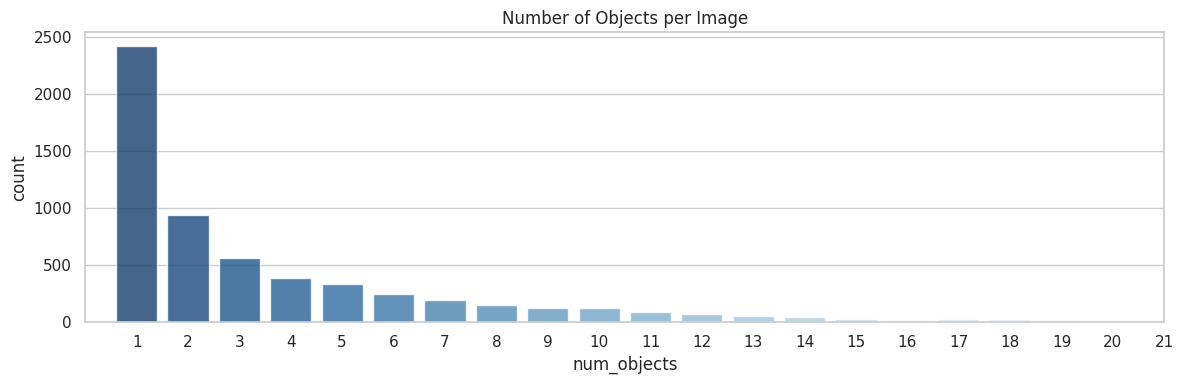

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

df = train_image_data[['num_objects']].head(25)

sns.countplot(data=train_image_data, x='num_objects', palette=blues_palette, alpha=0.8, ax=ax)
ax.set_title('Number of Objects per Image')
ax.set_xlim(-1, 20)

plt.tight_layout()
plt.show()

In [17]:
categories = get_categories(object_detection_train)
display(categories)

,name,supercategory
id,,
1,Actiniaria,Anemone
2,Actinernus,Anemone
3,Actiniidae,Anemone
4,Actinoscyphia,Anemone
5,Bolocera,Anemone
...,...,...
286,Polychaeta,Worm
287,Polynoidae,Worm
288,Sabellidae,Worm


In [18]:
object_detection_eval = read_json(root / 'object_detection/eval.json')
eval_image_data = get_image_data(object_detection_eval)
display(eval_image_data)

,width,height,file_name,license,flickr_url,coco_url,date_captured
id,,,,,,,
1,1920,1079,4172b65a-8b4f-4175-94e4-00187e2d5f33.png,0,https://fathomnet.org/static/m3/framegrabs/Min...,https://fathomnet.org/static/m3/framegrabs/Min...,2019-09-24 12:11:05
2,713,425,9d263fd4-f786-42bf-8e0c-2d5be7c81b49.png,0,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-15 18:44:36
3,720,368,c114ccb9-cf89-4d98-807b-f8636477c6ca.png,0,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-09-08 14:41:18
4,718,365,95ba3acc-859b-4a99-8c30-b38a91a1be28.png,0,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-11-07 18:52:01
5,720,368,0c4bdb90-c715-4c01-81d1-aa7f49534ac7.png,0,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-12-06 20:00:00
...,...,...,...,...,...,...,...
10740,1920,1080,8c6fbb81-eaeb-488e-9ca8-95d92a70505d.png,0,https://fathomnet.org/static/m3/staging/Doc%20...,https://fathomnet.org/static/m3/staging/Doc%20...,2013-12-12 00:00:00
10741,720,486,f5d39dea-afb2-4ca7-b3a7-5ea35e038b98.png,0,https://fathomnet.org/static/m3/staging/Doc%20...,https://fathomnet.org/static/m3/staging/Doc%20...,2013-12-12 00:00:00
10742,1920,1080,5833854d-3d75-4a25-b419-5e332d5ba931.png,0,https://fathomnet.org/static/m3/staging/Doc%20...,https://fathomnet.org/static/m3/staging/Doc%20...,2013-12-12 00:00:00


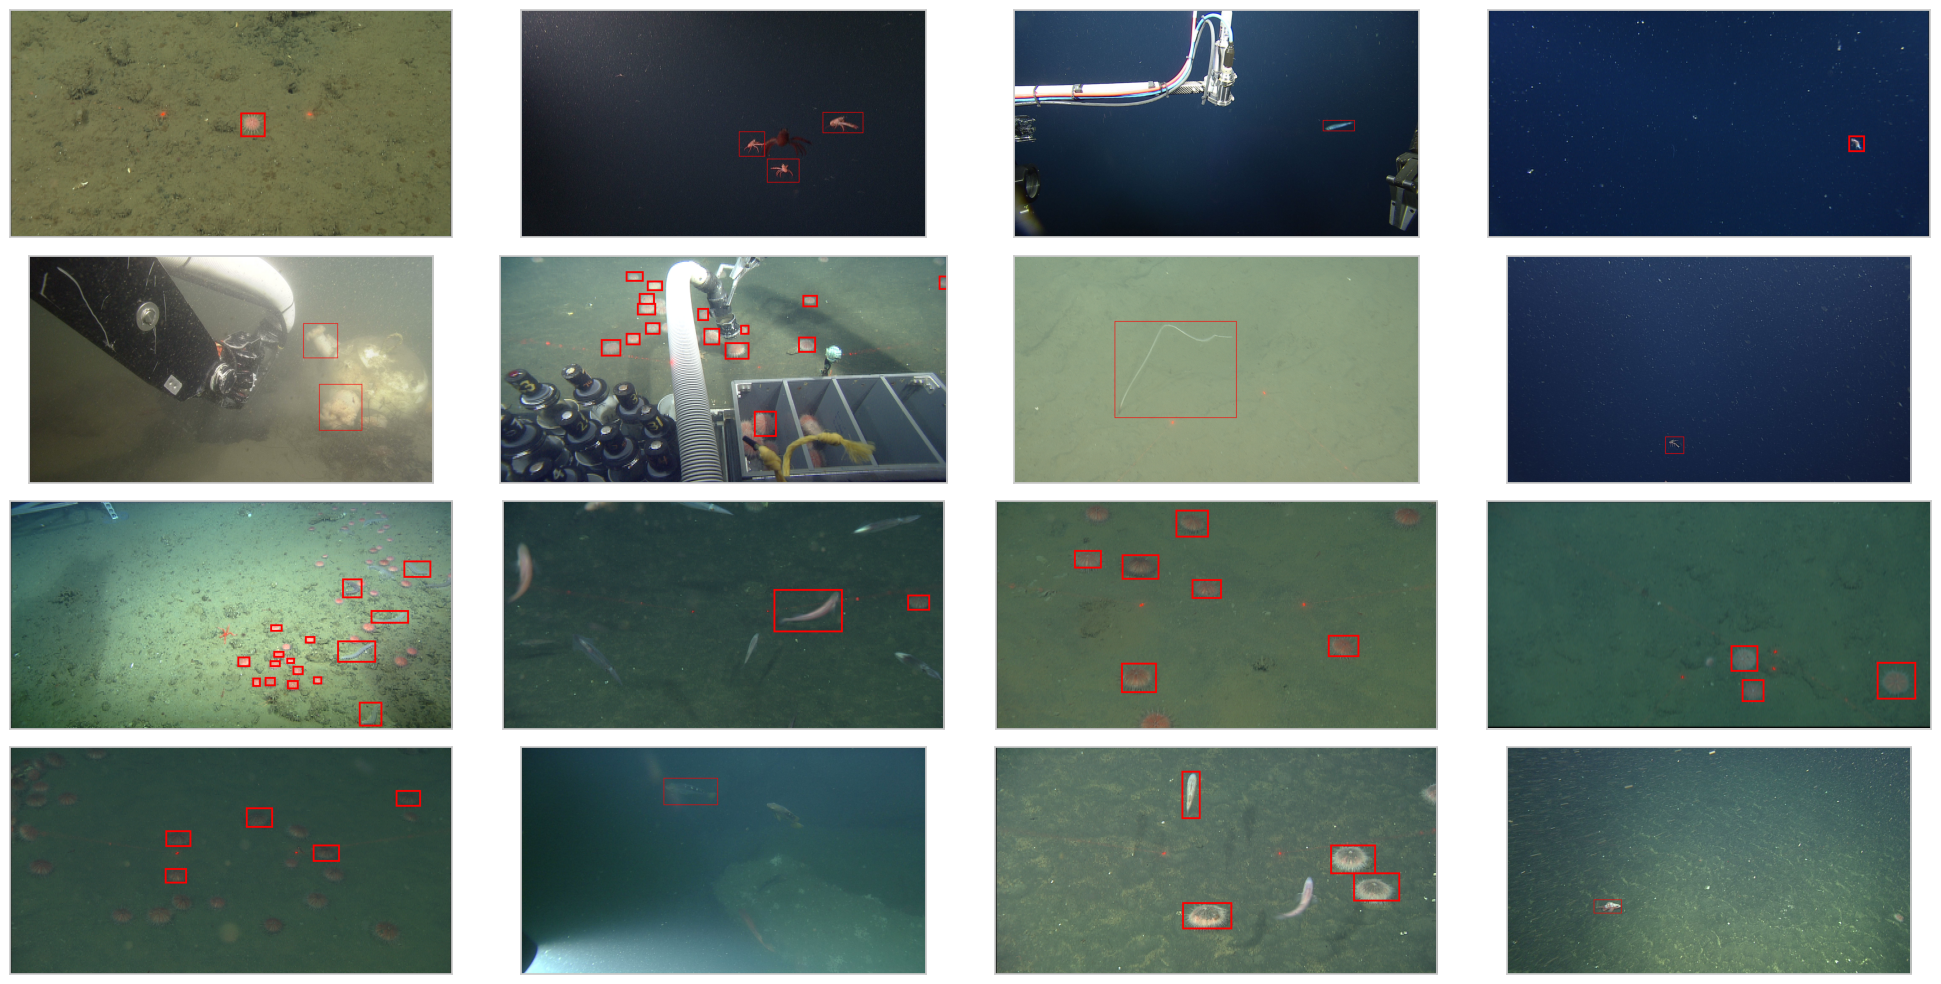

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))

image_ids = train_image_data.sample(n=16).index
for image_id, ax in zip(image_ids, axes.flatten()):
    
    # Load image
    image = download_image_by_id(train_image_data, image_id)

    # Get box coordinates
    bboxes = annotation_data[annotation_data['image_id'] == image_id]['bbox'].values

    # Draw boxes
    for coor in bboxes:
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[0] + coor[2], coor[1] + coor[3])
        draw_rectangle(image, xy=((x1, y1), (x2, y2)))
    
    ax.imshow(image)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    
fig.tight_layout()
plt.show()


In [20]:
submission = pd.read_csv(root / 'sample_submission.csv').set_index(indx)
print(submission)

                                              categories  osd
id                                                           
8119e2ac-ca3a-4c3b-9e1c-c7a079a705c8  1 146 10 12 44 210  0.1
11e2891-93a3-4532-a4ea-6e22e335ae54            17 82 251  0.9
